# Model the radial chemical gradients for a low-alpha young disc sample in 0.5kpc from the midplane using OTI

In [1]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData
from astropy.io import fits 
import tqdm
import os

jax.config.update("jax_enable_x64", True)

In [126]:
# LOAD THE DATA
path = '/Users/dhortad/Documents/Data/allstar-dr17-StarHorse-Gaiadr3-astroNNages'
tb = fits.open(path)
data = tb[1].data 

wmask = np.load('../sav/parent-mask-all.npy', allow_pickle=True)
# parent_mask = np.load('../sav/parent-mask.npy', allow_pickle=True)
# chem_mask = np.load('../sav/chemistry-mask.npy', allow_pickle=True)

print(len(data[wmask]))

21798


In [127]:
import astropy.units as u
x = data['xyz'][:,0]
y = data['xyz'][:,1]
z = data['xyz'][:,2]
vx = data['vxyz'][:,0]
vy = data['vxyz'][:,1]
vz = data['vxyz'][:,2]
vz = (vz*u.km/u.s)
vz = vz.to(u.kpc/u.Gyr)
x = x*u.kpc
y = y*u.kpc
z = z*u.kpc

# Eilers rotation curve
Rgal = np.sqrt(data['xyz'][:,0]**2+data['xyz'][:,1]**2)
vcirc = 229.-1.7*(Rgal-8.275)
Rg = -(data['L'][:,2]/vcirc)
deltaR = Rgal-Rg
phi = np.arctan(data['xyz'][:,1]/data['xyz'][:,0])

#transform to cylindrical velocities
vR = +data['vxyz'][:,0]*np.cos(phi)+data['vxyz'][:,1]*np.sin(phi)
vt = -data['vxyz'][:,0]*np.sin(phi)+data['vxyz'][:,1]*np.cos(phi)

In [128]:
# omask = (np.abs(z)<0.2*u.kpc)&(np.abs(vz)<20*u.kpc/u.Gyr)&(Rgal<15)&(Rgal>5)&(np.abs(vR)<125) # vr of 50 here caused we checked deltaR in Vr and found it is around 50
# # (np.abs(deltaR)<1)

In [129]:
wmask = parent_mask&chem_mask&omask

In [130]:
# create the bins to model the data in R-vR
nbins = 91
bins = {
    "pos": np.linspace(6, 14, nbins)*u.kpc,
    "vel": np.linspace(-125, 125, nbins)*u.km/u.s,
}

In [131]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)

Text(0, 0.5, '$v_R$ [$\\mathrm{kpc}$]')

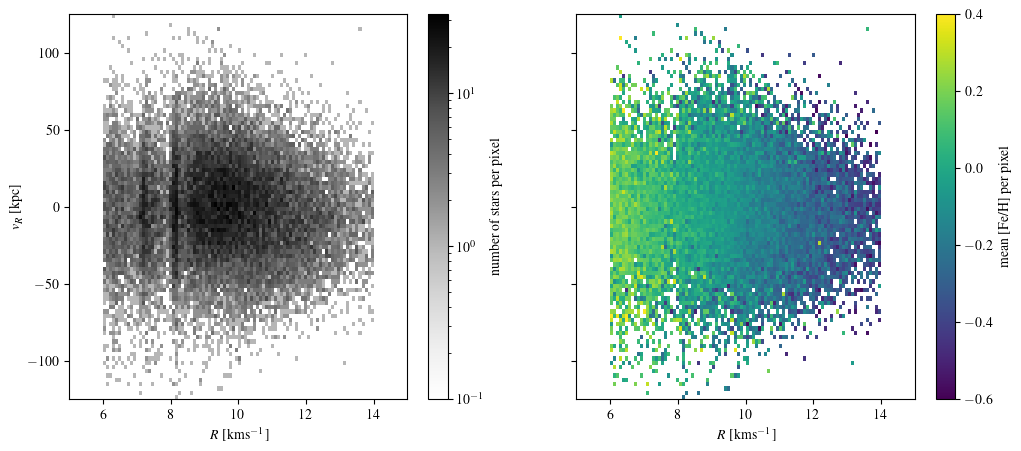

In [132]:
# visualise the data

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax = axes[0]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["counts"],
    norm=mpl.colors.LogNorm(vmin=0.1),
    cmap="Greys",
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("number of stars per pixel")

# ax.set_ylim(-100,100)
ax.set_xlim(0,16)

ax = axes[1]
cs = ax.pcolormesh(
    bdata["pos"].to_value(u.kpc),
    bdata["vel"].to_value(u.km / u.s),
    bdata["label"],
    vmin=-0.6,
    vmax=0.4,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Fe/H] per pixel")
# ax.set_ylim(-100,100)
ax.set_xlim(5,15)

for ax in axes:
    ax.set_xlabel(f"$R$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$v_R$ [{u.kpc:latex_inline}]")

In [133]:
model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=4,
    e_knots={2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={2: 1.0, 4: 1.0},
    e_smooth_sigmas={2: 0.5, 4: 0.5},
    dacc_strength=1e2,
    e_knots_spacing_power=0.5,
)


In [134]:
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], np.log(0.1 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.01 / model._label_knots.max())
)

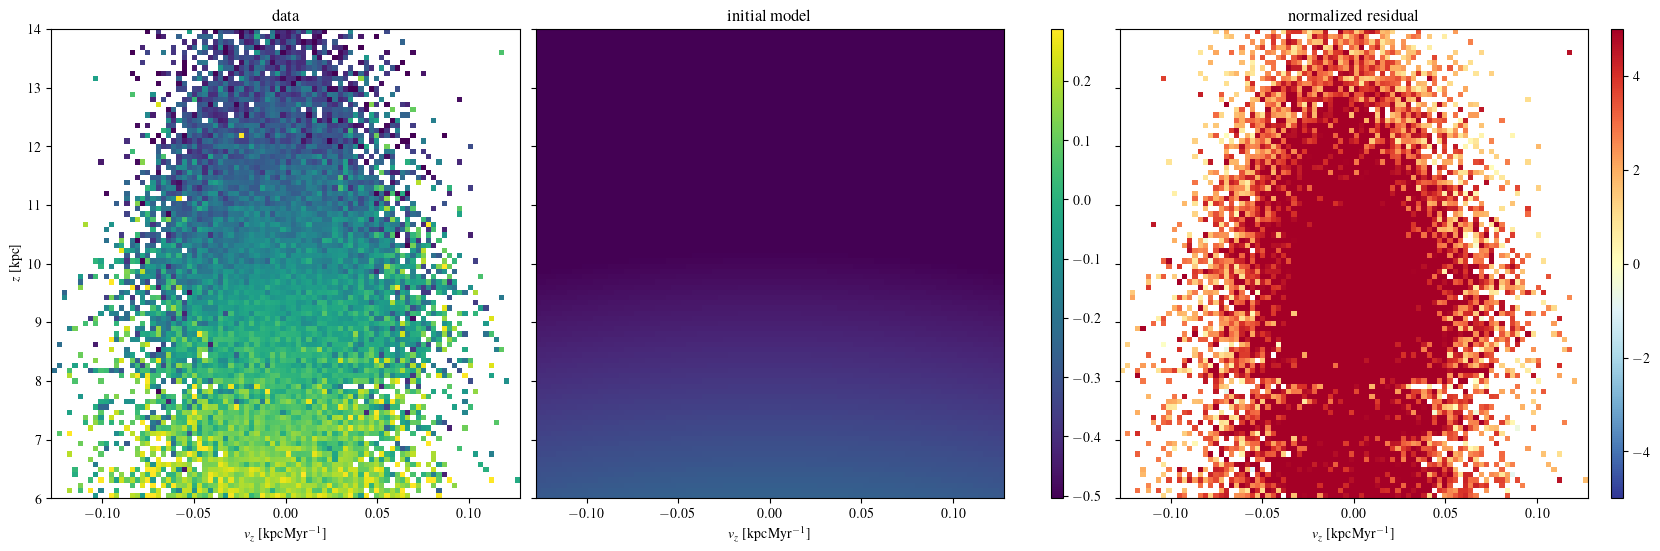

In [135]:
# initial guess, labels are wrong!
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model,
    init_params,
    vlim_residual=5,
    residual_normalization=bdata["label_err"],
)
_ = axes[1].set_title("initial model")

In [136]:
x_param = Rgal * u.kpc
y_param = vR * u.km/u.s
label = data['FE_H']
label_err = data['FE_H_ERR']

bdata = oti.data.get_binned_label(
    pos=x_param[wmask].astype(np.float32),
    vel=y_param[wmask].astype(np.float32),
    label=label[wmask].astype(np.float32),
    label_err=label_err[wmask].astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

In [137]:
bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

In [138]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 705)

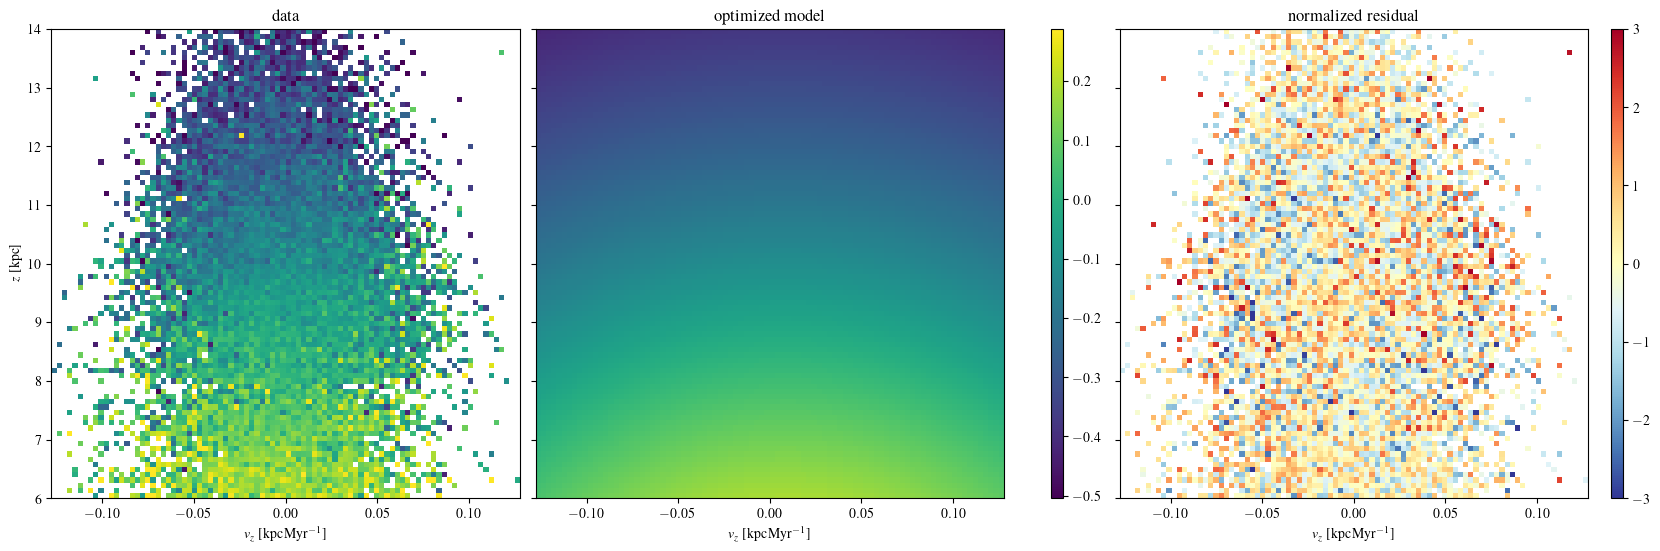

In [139]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata, model, res.params, vlim_residual=3, residual_normalization=bdata["label_err"]
)
_ = axes[1].set_title("optimized model")

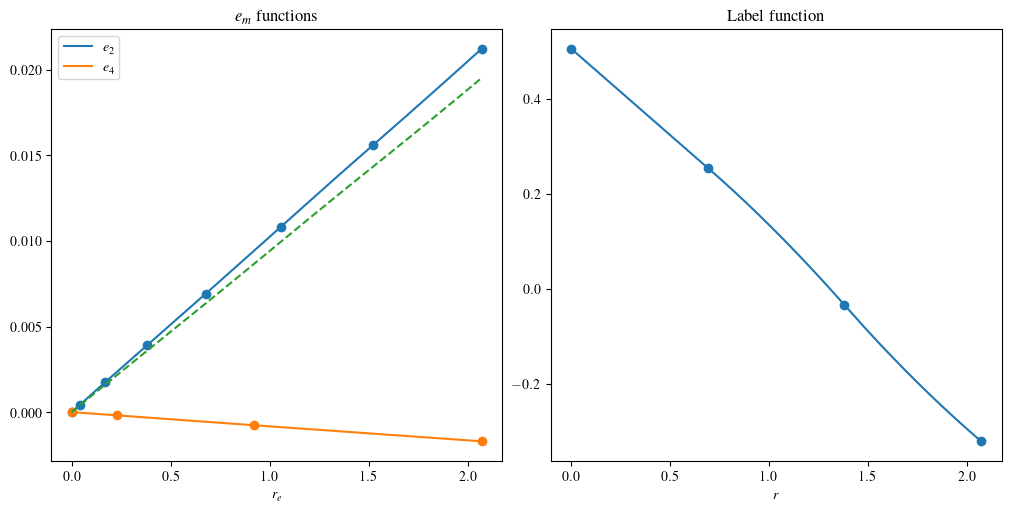

In [140]:
_ = oti.plot.plot_spline_functions(model, res.params)


# Model in bins of $R$

In [96]:
Rgal_cs = np.linspace(6,13,15)
Rgal_cs
# 

array([ 6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. ])

In [97]:
Rgal_cs = np.linspace(6,13,15)
bdatas = []
reses = []


for indx, Rg_c in tqdm.tqdm_notebook(enumerate(Rgal_cs)):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rg > Rg_l) & (Rg <= Rg_r) 
    # & (np.abs(vR)<20)&(deltaR<0.2)
    
    x_param = Rgal[wmask&Rg_mask] * u.kpc
    y_param = vR[wmask&Rg_mask] * u.km/u.s
    label = data['FE_H'][wmask&Rg_mask]
    label_err = data['FE_H_ERR'][wmask&Rg_mask]

    bdata = oti.data.get_binned_label(
        
        pos=x_param.astype(np.float32),
        vel=y_param.astype(np.float32),
        label=label.astype(np.float32),
        label_err=label_err.astype(np.float32),
        bins=bins,
        units=galactic,
        s_N_thresh=2,
    )

    bdata_clean = dict(
        pos=bdata["pos"],
        vel=bdata["vel"],
        label=bdata["label"],
        label_err=bdata["label_err"],
    )
    bdata_mask = (
        np.isfinite(bdata["label"])
        & np.isfinite(bdata["label_err"])
        & (bdata["label_err"] > 0)
    )
    bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

    res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
    
    bdatas.append(bdata_clean)
    reses.append(res)


0it [00:00, ?it/s]

In [98]:
acc_02 = np.zeros((len(reses)))
dens_02 = np.zeros((len(reses)))
R0s = np.zeros((len(reses)))
radial_period = np.zeros((len(reses)))

for idx, i in enumerate(reses):
    acc_02[idx] = -1.* np.exp(i.params['ln_Omega0']) **2 *(Rgal_cs[idx]+0.5) # Omega is in 1/Myr units
    # R0s[idx] = 8.275
    dens_02[idx] = (np.exp(i.params['ln_Omega0']) **2)/(4.*np.pi*G.value)
    radial_period[idx] = 2.*np.pi/(np.exp(i.params['ln_Omega0']))


In [99]:
acc_02 = acc_02*u.kpc/u.Myr**2
acc_02 = acc_02.to(u.km/(u.s*u.Myr))


Text(0, 0.5, 'Radial acceleration [km s$^{-1}$ Myr$^-1$]')

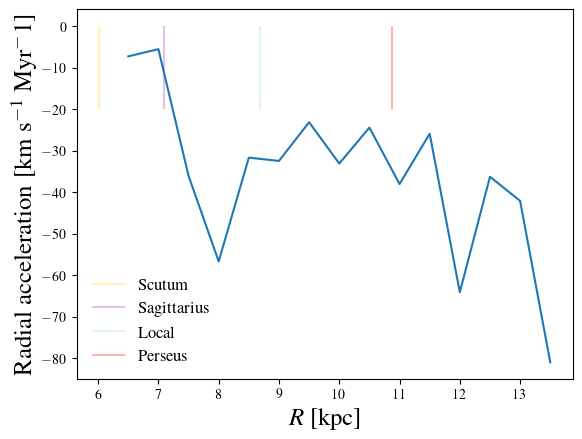

In [100]:
delta = 0.5
plt.plot(Rgal_cs+delta, acc_02)

plt.vlines(6.02,-20,0, color='gold',alpha=0.3, label='Scutum')
plt.vlines(7.1,-20,0, color='darkorchid',alpha=0.3, label='Sagittarius')
plt.vlines(8.69,-20,0, color='lightgreen',alpha=0.3, label='Local')
plt.vlines(10.88,-20,0, color='red',alpha=0.3, label='Perseus')
plt.legend(loc='lower left', frameon=False, fontsize=12)
# plt.ylim(-160,-50)
# plt.yscale('log')
plt.xlabel('$R$ [kpc]', fontsize=18)
plt.ylabel('Radial acceleration [km s$^{-1}$ Myr$^-1$]', fontsize=18)  

In [101]:
acc_02[4], acc_02[5]

(<Quantity -31.63902097 km / (Myr s)>, <Quantity -32.43917764 km / (Myr s)>)

In [102]:
dens_02 = dens_02 *(u.kg * u.s**2)/(u.m**3 * u.Myr**2)

In [103]:
dens_02 = dens_02.to(u.Msun/u.pc**3)

In [104]:
Rgal_cs

array([ 6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. ])

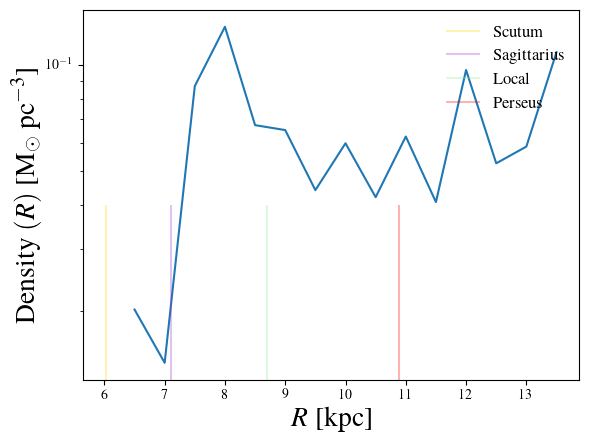

In [105]:
plt.plot(Rgal_cs+delta, dens_02)
plt.xlabel('$R$ [kpc]', fontsize=20)
plt.ylabel('Density $(R)$ [M$_{\odot}$ pc$^{-3}$]', fontsize=20)  
plt.yscale('log')
plt.vlines(6.02,0.01,0.04, color='gold',alpha=0.3, label='Scutum')
plt.vlines(7.1,0.01,0.04, color='darkorchid',alpha=0.3, label='Sagittarius')
plt.vlines(8.69,0.01,0.04, color='lightgreen',alpha=0.3, label='Local')
plt.vlines(10.88,0.01,0.04, color='red',alpha=0.3, label='Perseus')
plt.legend( frameon=False, fontsize=12, loc='upper right')
# plt.ylim(50,250)

# Try and back out a slope of the rotation curve

In [106]:
# fit the full sample first to get the overall acceleration
vR_mask = (np.abs(vR)<200)
# &(Rgal>8.)&(Rgal<8.5)

x_param = Rgal[wmask&vR_mask] * u.kpc
y_param = vR[wmask&vR_mask] * u.km/u.s
label = data['FE_H'][wmask&vR_mask]
label_err = data['FE_H_ERR'][wmask&vR_mask]

bdata = oti.data.get_binned_label(
    
    pos=x_param.astype(np.float32),
    vel=y_param.astype(np.float32),
    label=label.astype(np.float32),
    label_err=label_err.astype(np.float32),
    bins=bins,
    units=galactic,
    s_N_thresh=2,
)

bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)

bdatas.append(bdata_clean)
reses.append(res)

In [107]:
freq = np.exp(res.params['ln_Omega0'])*1./u.Myr
freq

<Quantity 0.0976224 1 / Myr>

In [108]:
acc = -freq **2 * 8.275*u.kpc
acc

<Quantity -0.07886185 kpc / Myr2>

In [109]:
vcirc = 229*u.km/u.s
dvc_dR = acc/(2.*vcirc)
dvc_dR = dvc_dR.to(u.km/u.s/u.kpc)
dvc_dR

<Quantity -164.62457347 km / (kpc s)>

In [110]:
vcirc = np.zeros((len(Rgal_cs)))
for idx, i in enumerate(Rgal_cs):
    vcirc[idx] = 229.+dvc_dR.value*(i-8.275)

In [111]:
vphis = np.zeros((len(Rgal_cs)))

for indx, Rg_c in tqdm.tqdm_notebook(enumerate(Rgal_cs)):
    Rg_l, Rg_r = (Rg_c, Rg_c + 1)
    Rg_mask = (Rgal > Rg_l) & (Rgal <= Rg_r) & (np.abs(vR)<20)&(deltaR<0.2)
    vphis[indx] = np.nanmean(vt[wmask&Rg_mask])

    

0it [00:00, ?it/s]

(0.0, 300.0)

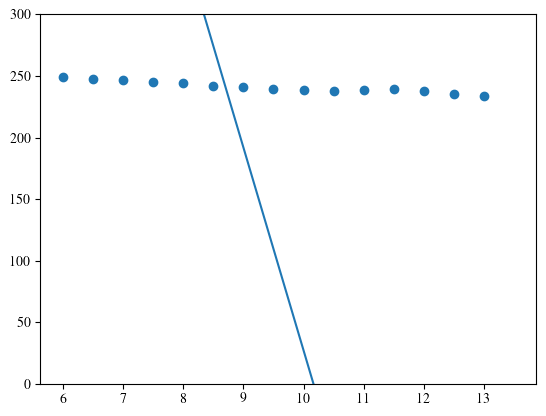

In [112]:
plt.plot(Rgal_cs+delta, vcirc)
plt.scatter(Rgal_cs, vphis)
plt.ylim(0,300)

In [ ]:
plt.